# Feature Selection Analysis: 16 Personality Types

This notebook performs feature selection to identify the most significant questions for predicting MBTI personality types. It uses **XGBoost** to rank features by importance and then performs a recursive analysis to determine the optimal number of questions to keep while maintaining high accuracy.

### **Objective**
Reduce the questionnaire length (from 60 questions) without significantly sacrificing prediction accuracy.

In [ ]:
# Install necessary libraries (if running in a fresh environment)
!pip install xgboost pandas seaborn scikit-learn numpy matplotlib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import os

# Set Plot Style
sns.set(style="whitegrid")

## 1. Load Data

In [ ]:
# Load the dataset
# NOTE: Upload '16P.csv' or '16P_cleaned.csv' to the Colab runtime before running.
file_path = '16P_cleaned.csv'

# Fallback if user uses the original filename
if not os.path.exists(file_path):
    if os.path.exists('16P.csv'):
        file_path = '16P.csv'
    else:
        print("\u26A0\uFE0F WARNING: Dataset file not found. Please upload '16P_cleaned.csv' or '16P.csv'.")

if os.path.exists(file_path):
    try:
        # Try default UTF-8 first
        df = pd.read_csv(file_path)
    except UnicodeDecodeError:
        print("UTF-8 decode failed, trying cp1252 (common for Windows files)...")
        # Fallback to cp1252 which handles smart quotes/special chars often found in survey data
        df = pd.read_csv(file_path, encoding='cp1252')

    print(f"Success: Loaded {file_path} with shape {df.shape}")
else:
    df = pd.DataFrame() # Empty placeholder

UTF-8 decode failed, trying cp1252 (common for Windows files)...
Success: Loaded 16P.csv with shape (59999, 62)


## 2. Preprocessing
We remove the identifiers and any derived scores, keeping only the raw question responses and the target 'Personality'.

In [ ]:
if not df.empty:
    # Drop identifier if exists
    if 'Response Id' in df.columns:
        df = df.drop(columns=['Response Id'])

    # Identify columns to drop (derived scores, etc.)
    cols_to_drop = ['Personality', 'E_I_score', 'S_N_score', 'T_F_score', 'J_P_score',
                    'E_I_strength', 'S_N_strength', 'T_F_strength', 'J_P_strength',
                    'is_Extraverted', 'is_Intuitive', 'is_Feeling', 'is_Judging',
                    'Consistency', 'Original_Personality']

    # Filter columns that actually exist in the dataframe
    cols_to_drop = [c for c in cols_to_drop if c in df.columns]

    X = df.drop(columns=cols_to_drop)
    y = df['Personality']

    feature_names = X.columns.tolist()
    print(f"Features (Questions): {len(feature_names)}")
    print(f"Target Classes: {y.nunique()} ({', '.join(y.unique()[:5])}...)")

    # Encode Target
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Split data (70% Train, 15% Validation, 15% Test)
    TEST_SIZE = 0.15      # 15% for test
    VAL_SIZE = 0.176      # 15% of remaining 85% = 15% of total

    # First split: 85% train+val, 15% test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y_encoded,
        test_size=TEST_SIZE,
        random_state=42,
        stratify=y_encoded
    )

    # Second split: 70% train, 15% val (of total)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=VAL_SIZE,
        random_state=42,
        stratify=y_temp
    )

    print(f"Training set:   {len(X_train):,} samples ({len(X_train)/len(df)*100:.1f}%)")
    print(f"Validation set: {len(X_val):,} samples ({len(X_val)/len(df)*100:.1f}%)")
    print(f"Test set:       {len(X_test):,} samples ({len(X_test)/len(df)*100:.1f}%)")

Features (Questions): 60
Target Classes: 16 (ENFP, ISFP, INFJ, ISTP, ENFJ...)
Training set:   42,023 samples (70.0%)
Validation set: 8,976 samples (15.0%)
Test set:       9,000 samples (15.0%)


## 3. Feature Importance with XGBoost
We train a robust XGBoost classifier on all 60 features to establish a baseline and extract feature importance scores.

In [ ]:
if not df.empty:
    print("Training XGBoost model (Baseline)...")

    # Configure XGBoost (matching ML_Comparison_Analysis.ipynb)
    xgb_params = {
        'n_estimators': 500,
        'learning_rate': 0.1,
        'max_depth': 6,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'objective': 'multi:softprob',
        'num_class': len(le.classes_),
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0
    }

    print("Hyperparameters:")
    for key, value in xgb_params.items():
        if key not in ['verbosity', 'n_jobs']:
            print(f"  {key}: {value}")

    # Train model with early stopping enabled (using validation set)
    model = XGBClassifier(**xgb_params, early_stopping_rounds=15)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    baseline_acc = accuracy_score(y_test, model.predict(X_test))
    print(f"Baseline Accuracy (All 60 Features): {baseline_acc:.4f} (Should match ML Comparison Notebook)")

    # Extract Feature Importances
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    print("Top 10 Most Important Features:")
    print(feature_importance_df.head(10))

Training XGBoost model (Baseline)...
Hyperparameters:
  n_estimators: 500
  learning_rate: 0.1
  max_depth: 6
  min_child_weight: 1
  subsample: 0.8
  colsample_bytree: 0.8
  objective: multi:softprob
  num_class: 16
  random_state: 42
Baseline Accuracy (All 60 Features): 0.9816 (Should match ML Comparison Notebook)
Top 10 Most Important Features:
                                             Feature  Importance
0  You are not too interested in discussing vario...    0.031854
1  At social events, you rarely try to introduce ...    0.031379
2                    You enjoy going to art museums.    0.030835
3  You are prone to worrying that things will tak...    0.029766
4        You like to have a to-do list for each day.    0.029043
5  You are more inclined to follow your head than...    0.027579
6  You often end up doing things at the last poss...    0.027554
7  You usually prefer just doing what you feel li...    0.027292
8  Your happiness comes more from helping others ...    0.026485


/tmp/ipython-input-2712294005.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')


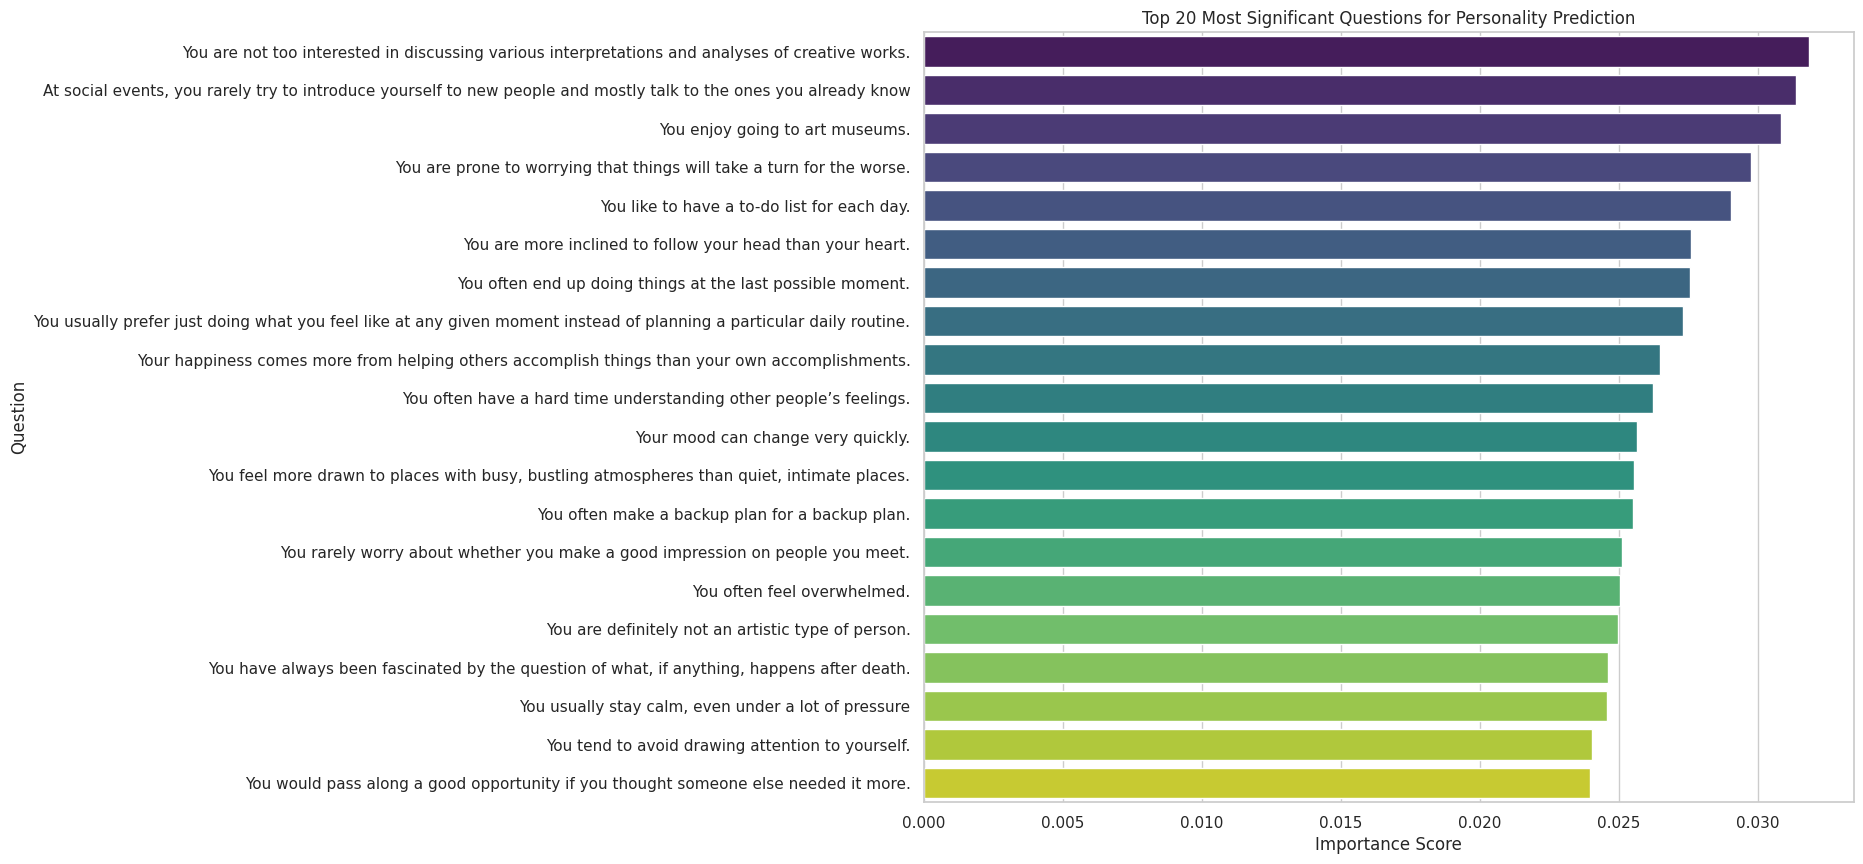

In [ ]:
# Plot Top 20 Features
if not df.empty:
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
    plt.title('Top 20 Most Significant Questions for Personality Prediction')
    plt.xlabel('Importance Score')
    plt.ylabel('Question')
    plt.show()

## 4. Recursive Stepwise Analysis (Top N)
We will now iteratively train models using only the Top N features. we check N=1 to 20 individually to observe the critical Pareto distribution, and then in larger steps.

In [ ]:
results = []
# Check Top 1-20 individually, then every 5
n_features_list = list(range(1, 21)) + list(range(25, 65, 5))

if not df.empty:
    print("Starting Stepwise Analysis...")
    for n in n_features_list:
        top_n_feats = feature_importance_df['Feature'].head(n).tolist()

        # Subset data to just Top N columns
        X_train_sub = X_train[top_n_feats]
        X_test_sub = X_test[top_n_feats]
        X_val_sub = X_val[top_n_feats]

        # Train sub-model with same hyperparameters and early stopping
        model_sub = XGBClassifier(**xgb_params, early_stopping_rounds=15)
        model_sub.fit(X_train_sub, y_train, eval_set=[(X_val_sub, y_val)], verbose=False)

        acc = accuracy_score(y_test, model_sub.predict(X_test_sub))

        results.append({'N_Features': n, 'Accuracy': acc})
        print(f"-> Top {n} Questions: Accuracy = {acc:.4f}")

    results_df = pd.DataFrame(results)

Starting Stepwise Analysis...
-> Top 1 Questions: Accuracy = 0.0999
-> Top 2 Questions: Accuracy = 0.1290
-> Top 3 Questions: Accuracy = 0.1974
-> Top 4 Questions: Accuracy = 0.2714
-> Top 5 Questions: Accuracy = 0.3456
-> Top 6 Questions: Accuracy = 0.4080
-> Top 7 Questions: Accuracy = 0.4686
-> Top 8 Questions: Accuracy = 0.5186
-> Top 9 Questions: Accuracy = 0.5780
-> Top 10 Questions: Accuracy = 0.6156
-> Top 11 Questions: Accuracy = 0.6671
-> Top 12 Questions: Accuracy = 0.7140
-> Top 13 Questions: Accuracy = 0.7446
-> Top 14 Questions: Accuracy = 0.7864
-> Top 15 Questions: Accuracy = 0.8117
-> Top 16 Questions: Accuracy = 0.8324
-> Top 17 Questions: Accuracy = 0.8502
-> Top 18 Questions: Accuracy = 0.8690
-> Top 19 Questions: Accuracy = 0.8850
-> Top 20 Questions: Accuracy = 0.8997
-> Top 25 Questions: Accuracy = 0.9448
-> Top 30 Questions: Accuracy = 0.9660
-> Top 35 Questions: Accuracy = 0.9770
-> Top 40 Questions: Accuracy = 0.9818
-> Top 45 Questions: Accuracy = 0.9833
-> T

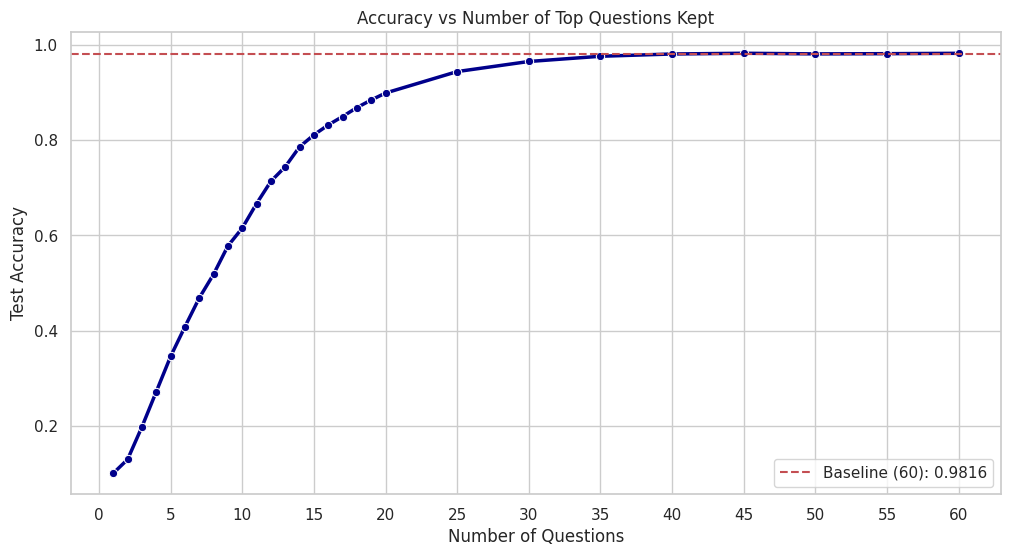

In [ ]:
if not df.empty:
    # Plot Accuracy vs N Features
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='N_Features', y='Accuracy', data=results_df, marker='o', linewidth=2.5, color='darkblue')
    plt.axhline(y=baseline_acc, color='r', linestyle='--', label=f'Baseline (60): {baseline_acc:.4f}')
    plt.title('Accuracy vs Number of Top Questions Kept')
    plt.xlabel('Number of Questions')
    plt.ylabel('Test Accuracy')
    plt.xticks(list(range(0, 65, 5)))
    plt.grid(True)
    plt.legend()
    plt.show()

## 5. Recommendation
Based on the analysis above, we suggest a cut-off point.

In [ ]:
if not df.empty:
    # Define threshold as 98% of baseline accuracy
    threshold_98 = 0.98 * baseline_acc
    threshold_95 = 0.95 * baseline_acc

    rec_98 = results_df[results_df['Accuracy'] >= threshold_98]['N_Features'].min()
    rec_95 = results_df[results_df['Accuracy'] >= threshold_95]['N_Features'].min()

    print("="*50)
    print("RECOMMENDATION")
    print("="*50)
    print(f"Baseline Accuracy (60 Questions): {baseline_acc:.4f}")
    print(f"- To maintain >98% accuracy ({threshold_98:.4f}): Keep Top {rec_98} Questions")
    print(f"- To maintain >95% accuracy ({threshold_95:.4f}): Keep Top {rec_95} Questions")

RECOMMENDATION
Baseline Accuracy (60 Questions): 0.9816
- To maintain >98% accuracy (0.9619): Keep Top 30 Questions
- To maintain >95% accuracy (0.9325): Keep Top 25 Questions


## 6. Export Models for Website Deployment
This section exports both the **full model (60 questions)** and **short model (35 questions)** to ONNX format for website deployment.

In [ ]:
# Install ONNX libraries
!pip install onnx onnxruntime onnxmltools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.0/304.0 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.2/317.2 kB 20.7 MB/s eta 0:00:00


In [ ]:
# === COMPLETE EXPORT SOLUTION (with all fixes) ===
import onnxmltools
from onnxmltools.convert.common.data_types import FloatTensorType
import onnxruntime as ort
import json

# Step 1: Rename columns to f0, f1, f2... (REQUIRED for ONNX conversion)
print("Step 1: Renaming columns to numeric format for ONNX compatibility...")
feature_mapping = {f'f{i}': feat for i, feat in enumerate(feature_names)}
X_train_r = X_train.copy()
X_val_r = X_val.copy()
X_test_r = X_test.copy()
X_train_r.columns = [f'f{i}' for i in range(60)]
X_val_r.columns = [f'f{i}' for i in range(60)]
X_test_r.columns = [f'f{i}' for i in range(60)]
print("Done!")

# Step 2: Retrain FULL model with numeric column names
print("\nStep 2: Training Full Model (60 questions) with numeric feature names...")
model_full = XGBClassifier(**xgb_params, early_stopping_rounds=15)
model_full.fit(X_train_r, y_train, eval_set=[(X_val_r, y_val)], verbose=False)
full_acc = accuracy_score(y_test, model_full.predict(X_test_r))
print(f"Full Model Accuracy: {full_acc:.4f} ({full_acc*100:.2f}%)")

# Step 3: Retrain SHORT model (35 questions) with SEQUENTIAL feature names (f0-f34)
# CRITICAL: ONNX requires sequential feature names, not the original indices!
TOP_N = 35
top_35_orig = feature_importance_df['Feature'].head(TOP_N).tolist()
top_35_idx = [feature_names.index(f) for f in top_35_orig]  # Original indices for reference
top_35_cols_orig = [f'f{i}' for i in top_35_idx]  # Columns in the renamed full dataset

# Create SHORT dataset with SEQUENTIAL names (f0, f1, f2, ..., f34)
X_train_short = X_train_r[top_35_cols_orig].copy()
X_val_short = X_val_r[top_35_cols_orig].copy()
X_test_short = X_test_r[top_35_cols_orig].copy()
X_train_short.columns = [f'f{i}' for i in range(TOP_N)]  # Rename to f0, f1, f2, ...
X_val_short.columns = [f'f{i}' for i in range(TOP_N)]
X_test_short.columns = [f'f{i}' for i in range(TOP_N)]

print(f"\nStep 3: Training Short Model ({TOP_N} questions)...")
print(f"Using features with SEQUENTIAL names: f0 through f{TOP_N-1}")
model_short = XGBClassifier(**xgb_params, early_stopping_rounds=15)
model_short.fit(X_train_short, y_train, eval_set=[(X_val_short, y_val)], verbose=False)
short_acc = accuracy_score(y_test, model_short.predict(X_test_short))
print(f"Short Model Accuracy: {short_acc:.4f} ({short_acc*100:.2f}%)")
print(f"Accuracy Retention: {(short_acc/full_acc)*100:.1f}% of full model")

Step 1: Renaming columns to numeric format for ONNX compatibility...
Done!

Step 2: Training Full Model (60 questions) with numeric feature names...
Full Model Accuracy: 0.9816 (98.16%)

Step 3: Training Short Model (35 questions)...
Using features with SEQUENTIAL names: f0 through f34
Short Model Accuracy: 0.9770 (97.70%)
Accuracy Retention: 99.5% of full model


In [ ]:
# Step 4: Convert models to ONNX and save all files
print("="*50)
print("Step 4: EXPORTING FILES FOR WEBSITE")
print("="*50)

def to_onnx(m, n, path):
    onx = onnxmltools.convert_xgboost(m, initial_types=[('float_input', FloatTensorType([None, n]))], target_opset=12)
    with open(path, 'wb') as f:
        f.write(onx.SerializeToString())
    ort.InferenceSession(path)  # Verify it loads
    print(f'\u2705 {path}')

# Export ONNX models
to_onnx(model_full, 60, 'mbti_model.onnx')
to_onnx(model_short, TOP_N, 'mbti_model_short.onnx')

# Export JSON metadata
with open('labels.json', 'w') as f:
    json.dump(list(le.classes_), f)
print('\u2705 labels.json')

with open('top_35_questions.json', 'w') as f:
    json.dump({
        'count': TOP_N,
        'indices': top_35_idx,
        'features': top_35_orig
    }, f, indent=2)
print('\u2705 top_35_questions.json')

with open('all_questions.json', 'w') as f:
    json.dump(feature_names, f, indent=2)
print('\u2705 all_questions.json')

with open('accuracy_report.json', 'w') as f:
    json.dump({
        'full_model_accuracy': round(full_acc, 4),
        'short_model_accuracy': round(short_acc, 4),
        'accuracy_retention_percent': round((short_acc/full_acc)*100, 2)
    }, f, indent=2)
print('\u2705 accuracy_report.json')

print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(f"Full Model (60Q):  {full_acc*100:.2f}%")
print(f"Short Model (35Q): {short_acc*100:.2f}%")
print(f"Accuracy Retention: {(short_acc/full_acc)*100:.1f}%")
print("="*50)

Step 4: EXPORTING FILES FOR WEBSITE
✅ mbti_model.onnx
✅ mbti_model_short.onnx
✅ labels.json
✅ top_35_questions.json
✅ all_questions.json
✅ accuracy_report.json

SUMMARY
Full Model (60Q):  98.16%
Short Model (35Q): 97.70%
Accuracy Retention: 99.5%


In [ ]:
# Step 5: Auto-download all files (Colab)
from google.colab import files

print('Downloading files...')
print('(Click "Allow" if prompted by browser)')

files.download('mbti_model.onnx')          # Full model (60 questions)
files.download('mbti_model_short.onnx')    # Short model (35 questions)
files.download('labels.json')              # Class labels
files.download('top_35_questions.json')    # Short model question indices
files.download('all_questions.json')       # All 60 questions
files.download('accuracy_report.json')     # Accuracy comparison

print('\n\u2705 All files downloaded!')

(Click "Allow" if prompted by browser)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ All files downloaded!


## 📁 Where to Place Downloaded Files

After downloading, place the files in your repo:

| File | Location |
|------|----------|
| `mbti_model.onnx` | `mbti-quiz/api/` |
| `mbti_model_short.onnx` | `mbti-quiz/api/` |
| `labels.json` | `mbti-quiz/api/` |
| `top_35_questions.json` | `mbti-quiz/api/` |
| `all_questions.json` | `mbti-quiz/api/` (optional) |
| `accuracy_report.json` | `Feature_Selection_Analysis/` (for reference) |